In [1]:
import pandas as pd
import numpy as np
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import tempfile
from sklearn.preprocessing import LabelEncoder

In [2]:
# Step 1: Load the historical data
data = pd.read_csv("data/INVEST_clean.csv", parse_dates=["Date"])

# Step 2: Load the historical exchange rates dataset
historical_exchange_rates = pd.read_csv("data/HistoricalRandPerUSDRateDetail.csv", parse_dates=["Date"])

# Step 3: Filter the data for General Industrials and Consumer Services sectors (2015-2018)
general_industrials_companies = [
    "SUPER GROUP", "PPC", "NAMPAK", "MURRAY & ROBERTS", "KAP INDUSTRIAL",
    "INVICTA", "IMPERIAL", "BIDVEST GROUP", "BARLOWORLD", "AFRIMAT"
]
consumer_services_companies = [
    "WOOLWORTHS HDG", "TSOGO SUN", "TRUWORTHS INTL"
]

filtered_data = data[
    (data['Date'].dt.year >= 2015) & 
    (data['Date'].dt.year <= 2018) & 
    (data['Name'].isin(general_industrials_companies + consumer_services_companies))
].copy()

# Step 4: Merge filtered_data with historical_exchange_rates on Date
filtered_data = pd.merge(filtered_data, historical_exchange_rates, on="Date", how="left")
filtered_data.rename(columns={'Value': 'ExchangeRate'}, inplace=True)

# Handle missing exchange rate data
filtered_data['ExchangeRate'].fillna(filtered_data['ExchangeRate'].mean(), inplace=True)

# Step 5: Discretize Exchange Rate into categories (Low/Medium/High)
filtered_data['ExchangeRate'] = pd.qcut(filtered_data['ExchangeRate'], q=3, labels=['Low', 'Medium', 'High'])

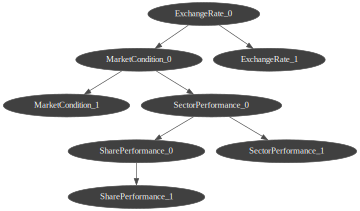

In [3]:
# Step 6: Define temporal variables and encode categorical variables
filtered_data['MarketCondition'] = np.where(filtered_data['Price'] > filtered_data['Price'].mean(), 'Good', 'Bad')
filtered_data['SectorPerformance'] = np.where(filtered_data['PE'] > filtered_data['PE'].median(), 'Positive', 'Negative')

def get_share_performance(price):
    if price > filtered_data['Price'].quantile(0.75):
        return 'High'
    elif price > filtered_data['Price'].quantile(0.25):
        return 'Medium'
    else:
        return 'Low'

filtered_data['SharePerformance'] = filtered_data['Price'].apply(get_share_performance)

# Encode categorical variables
le_market = LabelEncoder()
le_sector = LabelEncoder()
le_share = LabelEncoder()
le_exchange_rate = LabelEncoder()

filtered_data['MarketCondition'] = le_market.fit_transform(filtered_data['MarketCondition'])
filtered_data['SectorPerformance'] = le_sector.fit_transform(filtered_data['SectorPerformance'])
filtered_data['SharePerformance'] = le_share.fit_transform(filtered_data['SharePerformance'])
filtered_data['ExchangeRate'] = le_exchange_rate.fit_transform(filtered_data['ExchangeRate'])

# Automatically create time slice columns
variables = ['MarketCondition', 'SectorPerformance', 'SharePerformance', 'ExchangeRate']

# Create slice_0 columns (current time slice)
for var in variables:
    filtered_data[f'{var}_0'] = filtered_data[var]

# Create slice_1 columns (next time slice) by shifting
for var in variables:
    filtered_data[f'{var}_1'] = filtered_data[var].shift(-1)

# Drop rows with NaN values in slice_1 columns
filtered_data.dropna(subset=[f'{var}_1' for var in variables], inplace=True)

# Convert `slice_1` columns to integer type to avoid floating points
for var in variables:
    filtered_data[f'{var}_1'] = filtered_data[f'{var}_1'].astype(int)

# Create the Dynamic Bayesian Network (DBN)
def initialize_dbn(include_exchange_rate=True):
    global dbn
    dbn = gum.BayesNet("Dynamic_BDN")

    # Define variables for time slice 0 and 1 dynamically based on inclusion of exchange rate
    active_vars = variables if include_exchange_rate else variables[:-1]
    
    for slice_num in [0, 1]:
        for var in active_vars:
            num_states = len(filtered_data[f"{var}_{slice_num}"].unique())  # Adjust number of states dynamically
            dbn.add(gum.LabelizedVariable(f"{var}_{slice_num}", f"{var} at time slice {slice_num}", num_states))

    # Define intra-slice arcs for slice_0
    dbn.addArc("MarketCondition_0", "SectorPerformance_0")
    dbn.addArc("SectorPerformance_0", "SharePerformance_0")

    if include_exchange_rate:
        dbn.addArc("ExchangeRate_0", "MarketCondition_0")  # External factor influence

    # Temporal arcs connecting slice 0 to slice 1
    for var in active_vars:
        dbn.addArc(f"{var}_0", f"{var}_1")

initialize_dbn(include_exchange_rate=True)

# Display the DBN structure
gnb.showBN(dbn)

In [4]:
# Parameter Learning for DBN using historical data
def learn_parameters_from_data(data, dbn, active_vars):
    columns = [f"{var}_0" for var in active_vars] + [f"{var}_1" for var in active_vars]
    
    with tempfile.NamedTemporaryFile(mode='w+', suffix=".csv", delete=False) as temp_file:
        data[columns].to_csv(temp_file.name, index=False)
        learner = gum.BNLearner(temp_file.name, dbn)
        learned_dbn = learner.learnParameters(dbn.dag())
        
    return learned_dbn

In [5]:
# Train the DBN
learned_dbn = learn_parameters_from_data(filtered_data, dbn, variables)

# Evidence for prediction (ensure correct type)
current_evidence = {
    "MarketCondition_0": int(le_market.transform(['Good'])[0]),  # Explicitly convert to int
    "ExchangeRate_0": int(le_exchange_rate.transform(['Low'])[0])
}

# Predict future states
inference = gum.LazyPropagation(learned_dbn)
inference.setEvidence(current_evidence)
inference.makeInference()

predicted_sector = inference.posterior("SectorPerformance_1")
predicted_share = inference.posterior("SharePerformance_1")

print(f"Predicted Sector Performance With Exchange Rate: {predicted_sector}")
print(f"Predicted Share Performance With Exchange Rate: {predicted_share}")

Predicted Sector Performance With Exchange Rate: 
  SectorPerformance|
0        |1        |
---------|---------|
 0.4799  | 0.5201  |

Predicted Share Performance With Exchange Rate: 
  SharePerformance_1         |
0        |1        |2        |
---------|---------|---------|
 0.2524  | 0.2514  | 0.4962  |



In [6]:
# Function to remove the exchange rate from DBN and relearn parameters
def update_dbn(include_exchange_rate):
    initialize_dbn(include_exchange_rate=include_exchange_rate)
    
    if include_exchange_rate:
        learned_dbn = learn_parameters_from_data(filtered_data, dbn, variables)
        # print("DBN trained with Exchange Rate.")
        return learned_dbn
    else:
        learned_dbn_without_exchange_rate = learn_parameters_from_data(filtered_data.drop(columns=['ExchangeRate']), dbn, variables[:-1])  # Exclude Exchange Rate variable
        # print("DBN trained without Exchange Rate.")
        return learned_dbn_without_exchange_rate


# Function to predict future states given a learned DBN and evidence
def predict_future_states(current_evidence, learned_dbn):
    inference = gum.LazyPropagation(learned_dbn)
    
    # Ensure evidence values are integers (for compatibility)
    current_evidence = {k: int(v) for k, v in current_evidence.items()}
    
    # Set evidence based on current market conditions
    inference.setEvidence(current_evidence)
    inference.makeInference()

    predicted_sector_performance = inference.posterior("SectorPerformance_1")
    predicted_share_performance = inference.posterior("SharePerformance_1")
    
    return predicted_sector_performance, predicted_share_performance

In [7]:
# Train and predict using the DBN without Exchange Rate
learned_dbn_without_exchange_rate = update_dbn(include_exchange_rate=False)

# Update evidence dictionary without `ExchangeRate_0`
current_evidence_without_rate = {
    "MarketCondition_0": int(le_market.transform(['Good'])[0]),
}

# Predict future states without Exchange Rate
try:
    predicted_sector_without_rate, predicted_share_without_rate = predict_future_states(current_evidence_without_rate, learned_dbn_without_exchange_rate)

    print(f"Predicted Sector Performance without Exchange Rate: {predicted_sector_without_rate}")
    print(f"Predicted Share Performance without Exchange Rate: {predicted_share_without_rate}")
except Exception as e:
    print(f"An error occurred during prediction without Exchange Rate: {e}")

Predicted Sector Performance without Exchange Rate: 
  SectorPerformance|
0        |1        |
---------|---------|
 0.4799  | 0.5201  |

Predicted Share Performance without Exchange Rate: 
  SharePerformance_1         |
0        |1        |2        |
---------|---------|---------|
 0.2524  | 0.2514  | 0.4962  |

